In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Subset

import torchvision
import torchvision.models 
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 42

random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

In [22]:
dataroot = "celeba"

workers = 2

batch_size = 128

image_size = 64

# number of channels
nc = 3 

# size of the latent vector (z)
nz = 100

# size of the feature maps in the generator
ngf = 64

# size of thr feature maps in the discriminator
ndf = 64

num_epochs = 5

lr = 0.0002

beta1 = 0.5

ngpu = 1

In [23]:
dataset  = dset.ImageFolder(root = dataroot,
                            transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ]))

In [24]:
fraction = 0.005
total_samples = len(dataset)
num_samples = int(total_samples * fraction)
indices = np.random.choice(total_samples, num_samples, replace=False)
subset_dataset = Subset(dataset, indices)

In [25]:
dataloader = torch.utils.data.DataLoader(subset_dataset, batch_size, shuffle=True, num_workers=workers)

In [26]:
inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.5, -0.5, -0.5], std=[2.0, 2.0, 2.0])  # Reverse the normalization
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-60.75..158.25].


[]

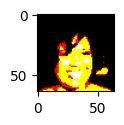

In [27]:
temp = inverse_transform(next(iter(dataloader))[0][100])
# temp = next(iter(dataloader))[0][100]
plt.figure(figsize=(1, 1))
# plt.imshow(np.transpose(next(iter(dataloader))[0][100]))
plt.imshow(temp.permute(1, 2, 0) * 255)
plt.plot()

In [28]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

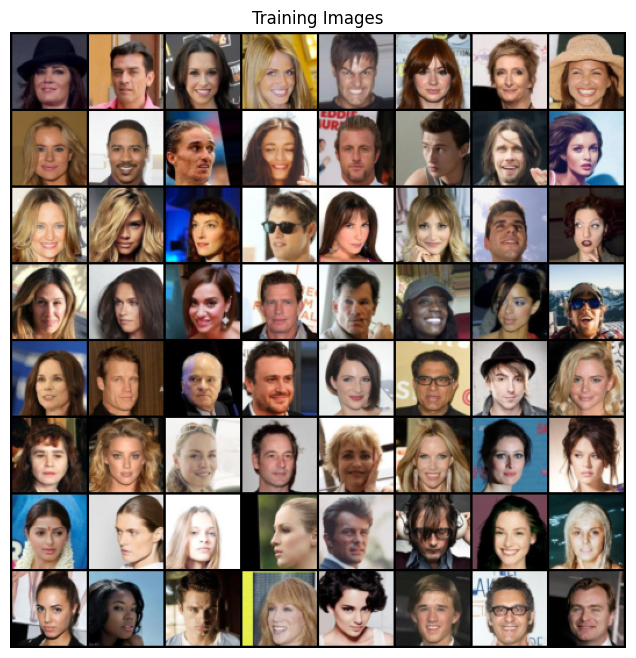

In [29]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [30]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [31]:
layer_info = []

def get_layer_info(m, info_list):
    # Get the class name of the layer
    classname = m.__class__.__name__
    # Check if the layer has weights
    if hasattr(m, 'weight') and m.weight is not None:
        weight_shape = m.weight.data.shape
    else:
        weight_shape = None
    # Check if the layer has biases
    if hasattr(m, 'bias') and m.bias is not None:
        bias_shape = m.bias.data.shape
    else:
        bias_shape = None
    # Append the layer's information to the info_list
    info_list.append({
        "layer_type": classname,
        "weight_shape": weight_shape,
        "bias_shape": bias_shape
    })

In [32]:
# Generator 

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # ngf*8 x 4 x 4

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # ngf*4 x 8 x 8

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # ngf*2 x 16 * 16

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # ngf x 32 x 32

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [33]:
netG = Generator(ngpu).to(device)
netG
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [34]:
netG.apply(lambda m: get_layer_info(m, layer_info))
layer_info

[{'layer_type': 'ConvTranspose2d',
  'weight_shape': torch.Size([100, 512, 4, 4]),
  'bias_shape': None},
 {'layer_type': 'BatchNorm2d',
  'weight_shape': torch.Size([512]),
  'bias_shape': torch.Size([512])},
 {'layer_type': 'ReLU', 'weight_shape': None, 'bias_shape': None},
 {'layer_type': 'ConvTranspose2d',
  'weight_shape': torch.Size([512, 256, 4, 4]),
  'bias_shape': None},
 {'layer_type': 'BatchNorm2d',
  'weight_shape': torch.Size([256]),
  'bias_shape': torch.Size([256])},
 {'layer_type': 'ReLU', 'weight_shape': None, 'bias_shape': None},
 {'layer_type': 'ConvTranspose2d',
  'weight_shape': torch.Size([256, 128, 4, 4]),
  'bias_shape': None},
 {'layer_type': 'BatchNorm2d',
  'weight_shape': torch.Size([128]),
  'bias_shape': torch.Size([128])},
 {'layer_type': 'ReLU', 'weight_shape': None, 'bias_shape': None},
 {'layer_type': 'ConvTranspose2d',
  'weight_shape': torch.Size([128, 64, 4, 4]),
  'bias_shape': None},
 {'layer_type': 'BatchNorm2d',
  'weight_shape': torch.Size([64]

In [35]:
# Discriminator

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        # 
        self.main = nn.Sequential(
            # nc x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # ndf x 32 x 32
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            # ndf*2 x 16 x 16
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            # ndf*4 x 8 x 8
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            # ndf*4 x 8 x 8
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [36]:
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [37]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

optimierD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimierG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [38]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}\n-------")

    for i, data in enumerate(dataloader, 0):
        ############################## 
        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ############################## 
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size, ), real_label, dtype=torch.float, device=device)
        # train for all-real batch
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        # train for all-fake batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimierD.step()

        ##############################
        # Update G network: maximize log(D(G(z)))
        ##############################

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimierG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        

        
        
        


Epoch: 0
-------
[0/5][0/8]	Loss_D: 1.7496	Loss_G: 2.6339	D(x): 0.3250	D(G(z)): 0.3091 / 0.1014
Epoch: 1
-------
[1/5][0/8]	Loss_D: 0.3590	Loss_G: 7.7558	D(x): 0.9228	D(G(z)): 0.1637 / 0.0007
Epoch: 2
-------
[2/5][0/8]	Loss_D: 0.1177	Loss_G: 9.2603	D(x): 0.9598	D(G(z)): 0.0541 / 0.0002
Epoch: 3
-------
[3/5][0/8]	Loss_D: 0.0596	Loss_G: 18.1788	D(x): 0.9511	D(G(z)): 0.0000 / 0.0000
Epoch: 4
-------
[4/5][0/8]	Loss_D: 0.0898	Loss_G: 25.8300	D(x): 0.9281	D(G(z)): 0.0000 / 0.0000


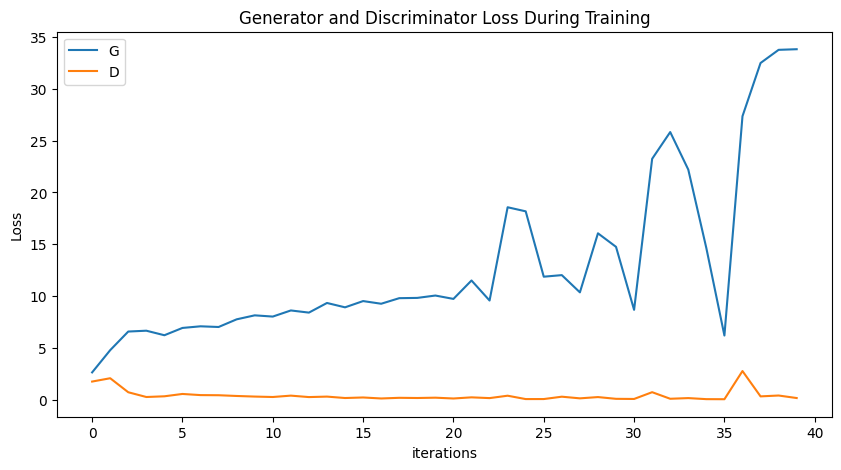

In [39]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

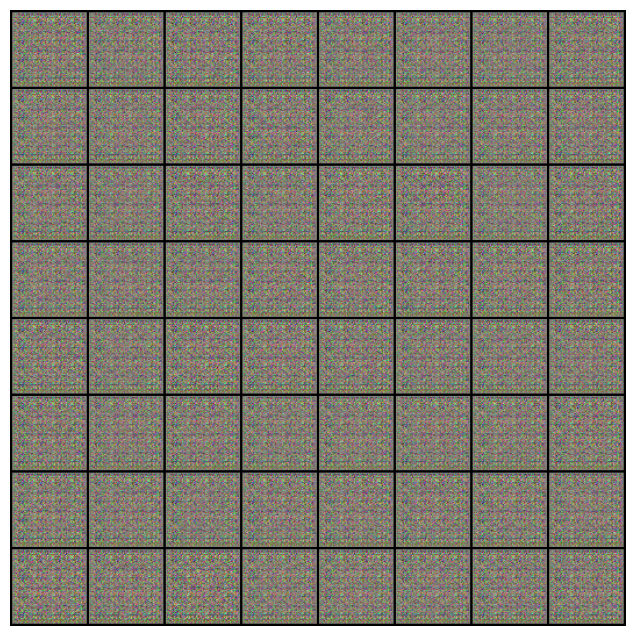

In [40]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

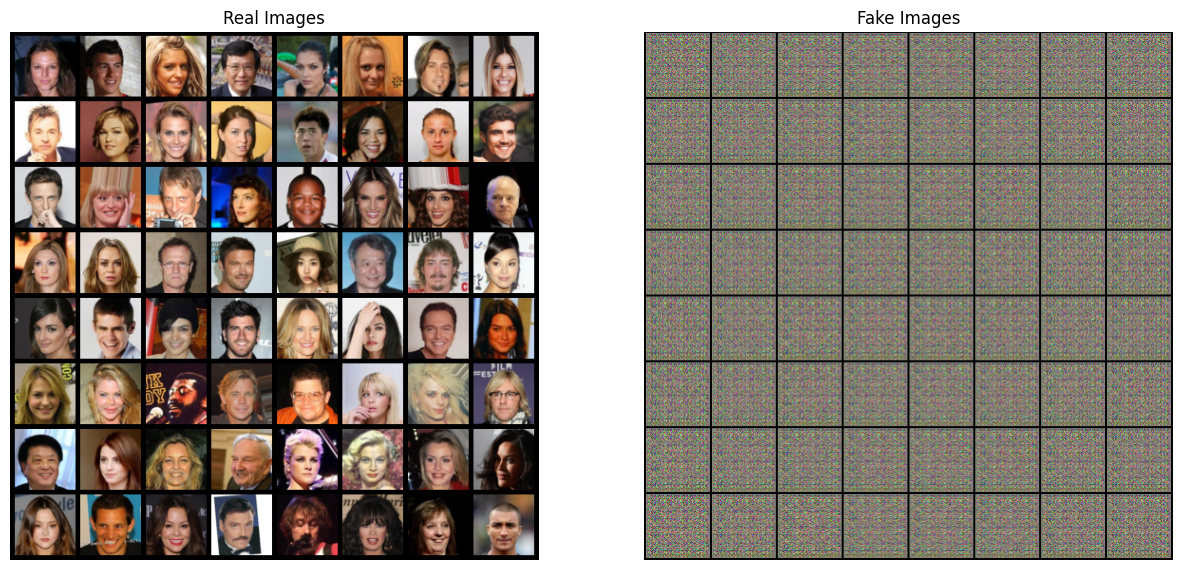

In [41]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()